# Model Order Reduction & Machine Learning - Project
## Nonlinear Elliptic problem POD vs PINNs

### Importing library

In [5]:
import sys
sys.path.append('../../CppToPython')

In [6]:
import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time

### Initialize

In [7]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## PART 1
Let us consider the two-dimensional spatial domain $\Omega = (0, 1)^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2$, find $u(\mu)$ such that
$$
-\Delta u(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 u(\mu)} - 1) = g(x;\mu),
$$
with homogeneous Dirichlet condition on the boundary, i.e. zero-boundary condition.

The forcing term, that does not depend on the parameters, defined as
$$
g(x;\mu) = g_1 = 100 \sin(2\pi x_0) \cos(2\pi x_1) \quad \forall x = (x_0, x_1) \in \Omega.
$$

**Tasks:**

1. Solve the problem by means of POD-Galerkin method over a Finite Element full order model -> using high fidelity element approximation of POD
2. Solve the problem with a parametric PINN -> find the NN structure to reduce the problem
3. Compare the two approaches in terms of computational costs and accuracy with respect to the full order model -> compare in terms of execution time & error
4. **Optional:** Solve the problem with the POD-NN approach and compare it to the other two strategies.

### Passage from Strong Formulation to Weak Formulation and Newton Scheme

**Consider the homogeneous Dirichlet problem for the equation:**
$$-\Delta u(X; \mu)+\frac{\mu_0}{\mu_1} (e^{\mu_1 u(X;\mu)}-1) = g(X;\mu) \quad \text{in } \Omega \text{ where } X = (x,y)$$
$$u = 0 \quad \text{on } \partial \Omega$$
where $\Omega \subset \mathbb{R}^2$ is a bounded domain with a regular boundary $\partial \Omega$. We seek a solution $u$ in $H_0^1(\Omega)$.

**Weak Formulation.**
Find $u \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX = 0$$

**Definition of the Nonlinear Operator.**
Define the operator $F: H_0^1(\Omega) \to (H_0^1(\Omega))'$ such that for $u \in H_0^1(\Omega)$ and $v \in H_0^1(\Omega)$:
$$F(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX - \int_{\Omega} g v \, dX$$

**Fréchet Derivative of $F(u)$.**
Calculate the Fréchet derivative $DF(u)[\delta u] \in (H_0^1(\Omega))'$ for an increment $\delta u \in H_0^1(\Omega)$. For every $v \in H_0^1(\Omega)$:
$$DF(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F(u + \epsilon \delta u)[v] - F(u)[v]}{\epsilon}$$
Consider each term of $F(u)[v]$ separately.

1.  **Linear Term.** $F_1(u)[v] = \int_{\Omega} \nabla u \cdot \nabla v \, dX$.
    $$DF_1(u)[\delta u][v] = \int_{\Omega} \nabla \delta u \cdot \nabla v \, dX$$

2.  **Nonlinear Term.** $F_2(u)[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} -1) v \, dX$.
    The Fréchet derivative of $F_2(u)$ is given by:
    $$DF_2(u)[\delta u][v] = \lim_{\epsilon \to 0} \frac{F_2(u + \epsilon \delta u)[v] - F_2(u)[v]}{\epsilon}$$
    **Expansion of $F_2(u + \epsilon \delta u)[v]$.**
    \begin{align*}
    F_2(u + \epsilon \delta u)[v] &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 (u + \epsilon \delta u)} - 1) v \, dX \\
    &= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - 1) v \, dX
    \end{align*}
    **Then**
    $$F_2(u + \epsilon \delta u)[v] - F_2(u)[v] = \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - 1) v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} - 1) v \, dX$$    $$= \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u} e^{\mu_1 \epsilon \delta u} - e^{\mu_1 u}) v \, dX = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u} (e^{\mu_1 \epsilon \delta u} - 1) v \, dX$$
    **Division by $\epsilon$.**
    $$\frac{F_2(u + \epsilon \delta u)[v] - F_2(u)[v]}{\epsilon} = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u} \frac{(e^{\mu_1 \epsilon \delta u} - 1)}{\epsilon} v \, dX$$
    **Notable Limit.**
    We use the notable limit $\lim_{t \to 0} \frac{e^{at} - 1}{t} = a$. In our case, $t = \epsilon$ and $a = \mu_1 \delta u(X)$. Thus:
    $$\lim_{\epsilon \to 0} \frac{e^{\mu_1 \epsilon \delta u(X)} - 1}{\epsilon} = \mu_1 \delta u(X)$$
    **Passing to the Limit.**
    $$DF_2(u)[\delta u][v] = \lim_{\epsilon \to 0} \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u(X)} \frac{(e^{\mu_1 \epsilon \delta u(X)} - 1)}{\epsilon} v(X) \, dX$$
    Assuming we can interchange the limit and the integral (which requires appropriate regularity conditions), we obtain:
    $$DF_2(u)[\delta u][v] = \int_{\Omega} \frac{\mu_0}{\mu_1} e^{\mu_1 u(X)} (\mu_1 \delta u(X)) v(X) \, dX = \int_{\Omega} \mu_0 e^{\mu_1 u(X)} \delta u(X) v(X) \, dX$$

3.  **Term Independent of $u$.** $F_3(u)[v] = - \int_{\Omega} g v \, dX$.
    $$DF_3(u)[\delta u][v] = 0$$

**The Jacobian Operator (Fréchet Derivative) of $F(u)$ is therefore**
$$DF(u)[\delta u][v] = \int_{\Omega} \nabla \delta u \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u} \delta u v \, dX$$

**Newton Scheme.**
The Newton scheme to find the root of $F(u) = 0$ is given by:
$$DF(u_k)[\delta u_k] = -F(u_k)$$
where $u_k$ is the approximation at the $k$-th iteration and $\delta u_k = u_{k+1} - u_k$ is the increment to be found. In variational form, this is written:

Find $\delta u_k \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla \delta u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} \delta u_k v \, dX = - \left( \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX - \int_{\Omega} g v \, dX \right)$$
**Rewriting the equation for the next iteration $u_{k+1} = u_k + \delta u_k$.**
Find $u_{k+1} \in H_0^1(\Omega)$ such that for every $v \in H_0^1(\Omega)$:
$$\int_{\Omega} \nabla (u_{k+1} - u_k) \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} (u_{k+1} - u_k) v \, dX = - \int_{\Omega} \nabla u_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$**Rearranging the terms, we obtain the variational form of the linear system to be solved at each Newton iteration to find $u_{k+1}$:**$$\int_{\Omega} \nabla u_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_{k+1} v \, dX = \int_{\Omega} \nabla u_k \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_k v \, dX - \int_{\Omega} \nabla u_k \cdot \nabla v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$**Which simplifies to**$$\int_{\Omega} \nabla u_{k+1} \cdot \nabla v \, dX + \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_{k+1} v \, dX = \int_{\Omega} \mu_0 e^{\mu_1 u_k} u_k v \, dX - \int_{\Omega} \frac{\mu_0}{\mu_1} (e^{\mu_1 u_k} -1) v \, dX + \int_{\Omega} g v \, dX$$

### Newton's Method for Nonlinear PDEs
**FINISH THE DEFINITION OF THE FUNCTION HERE**

In [ ]:
# Points on which we want to integrate
def Elliptic_a(numPoints, points): 
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Elliptic_b(numPoints, points):
	values_b = np.ones(numPoints, order='F') # np.ones((2, numPoints), order='F') perchè qua mette 2? è giusto mettere 2 oppure mettere 1?
	return values_b.ctypes.data    

In [ ]:
# Save the non linear part with x=x_0, y=x_1
def Elliptic_non_linear_b(numPoints, points, u, u_x, u_y): 
	vec_u = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in some points
	values_nl_b = vec_u
	return values_nl_b.ctypes.data

In [ ]:
# Definition of the forcing term g_1
def Elliptic_g_1(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	
    # g_1(X,mu) = 100*sin(2pi*x)*cos(2pi*y), X=(x,y)
    values_g = 100*sin(2*np.pi*matPoints[0,:])*cos(2*np.pi*matPoints[1,:])

	return values_g.ctypes.data

In [ ]:
# Primo integrale a dx
def Elliptic_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

In [ ]:
# Secondo integrale a dx
def Elliptic_non_linear_f(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_f = (mu_0/mu_1) * (exp(mu_1*vecu)-1) # CONTROLLARE EXP E IL RESTO!!
	return values_nl_f.ctypes.data

In [ ]:
def Elliptic_exactSolution(numPoints, points): # Exact solution u = 16 xy(1-x)(1-y) - CHE ABBIAMO DECISO DI USARE
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

In [ ]:
def Burger_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

**Define the High Fidelity Simulation Parameters**:
for a parametric problem we need not only the order of the discretization, but also the parametric space definition.

Penso che ci abbiano detto di partire con 1 e poi aumentare, ma è da capire. Il range per mu è giusto.

In [8]:
order = 2
mu_range = [0.1, 1.]

### Creating Mesh

Qui ho solo copiato il codice, NON va bene, bisogna che capiamo come creare la nostra mesh. Tendenzialmente è un quadrato [0,1], ma è da verificare non ci ho pensato.

In [9]:
%%writefile ImportMesh.csv
InputFolderPath
../../CppToPython/Meshes/Mesh1

Writing ImportMesh.csv


In [10]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

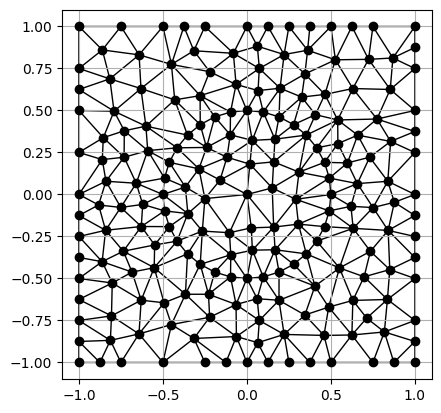

In [11]:
gedim.PlotMesh(mesh)

**Create Discrete Space FEM (the FOM approximation)**

Qua è quello che ci dicevamo, dobbiamo discretizzare lo spazio, ma bisogna capire come segnare i boundary.

In [12]:
#### Labels \Gamma_down = 1, \Gamma_side = 2 and \Gamma_top = 3
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

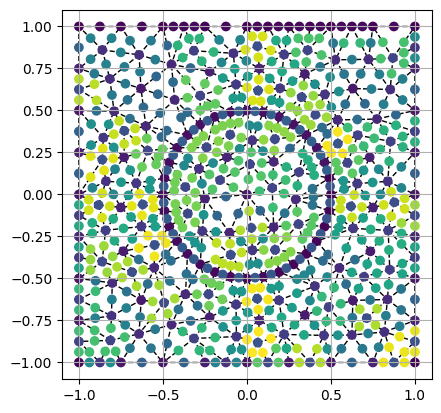

In [13]:
gedim.PlotDofs(mesh, dofs, strongs)